In [13]:
from __future__ import division

%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context('notebook', font_scale=1.3)

In [14]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))
import agent
import blockworld
import model

In [15]:
from utils import get_data
version = '1.1'
data = get_data(version, '../data')
df = data['blockworld']

Error importing rpy2


In [16]:
def parse_state(state):
    return tuple((tuple(filter(None, col.split(','))) 
                  for col in state.split(':')))

df.states = df.states.apply(lambda states: list(map(parse_state, states)))

Total elapsed for pid 0: 12.12425 minutes
Total elapsed for pid 1: 7.18415 minutes
Total elapsed for pid 2: 8.737316666666667 minutes
Total elapsed for pid 3: 9.147533333333334 minutes
Total elapsed for pid 4: 17.6569 minutes
Total elapsed for pid 5: 16.689583333333335 minutes
Total elapsed for pid 6: 5.5966499999999995 minutes
Total elapsed for pid 7: 8.375133333333332 minutes
Total elapsed for pid 8: 7.128033333333334 minutes
Total elapsed for pid 9: 7.490333333333334 minutes
Total elapsed for pid 10: 16.319416666666665 minutes
Total elapsed for pid 11: 5.841383333333334 minutes
Total elapsed for pid 12: 5.152583333333333 minutes
Total elapsed for pid 13: 4.784566666666667 minutes
Total elapsed for pid 14: 6.53735 minutes
Total elapsed for pid 15: 6.73015 minutes
Total elapsed for pid 16: 6.869316666666666 minutes
Total elapsed for pid 17: 7.699883333333333 minutes
Total elapsed for pid 18: 13.074433333333333 minutes
Total elapsed for pid 19: 12.416066666666667 minutes
Total elapsed 

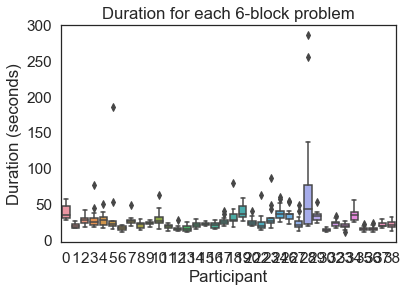

In [17]:
# How long did subjects take?

elapsed_df = []

all_min = []

for pid, pid_df in df.groupby('pid'):
    prev_row_elapsed = 0
    for _, row in pid_df.iterrows():
        elapsed_df.append(dict(
            pid=pid,
            duration_ms=row.time_elapsed - prev_row_elapsed,
            num_blocks=sum(len(col) for col in row.states[0]),
        ))
        prev_row_elapsed = row.time_elapsed

    minutes = prev_row_elapsed/1000/60
    print(f'Total elapsed for pid {pid}: {minutes} minutes')

    all_min.append(minutes)

print(f'Mean time {np.mean(all_min)} +- {np.std(all_min)}')

elapsed_df = pd.DataFrame(elapsed_df)
elapsed_df['duration'] = elapsed_df['duration_ms'] / 1000

sns.boxplot(x='pid', y='duration', data=elapsed_df.loc[elapsed_df.num_blocks == 6])
plt.title('Duration for each 6-block problem')
plt.ylabel('Duration (seconds)')
plt.xlabel('Participant')
None

In [18]:
# Cleaning erroneous data where some states are repeated.
# Totally strange, as we don't permit this in the UI... So we should also prohibit this in logic I think...
# TODO

for row_idx, row in df.iterrows():
    states = row.states

    result = []
    for idx, state in enumerate(states):
        if idx == 0 or state != states[idx-1]:
            result.append(state)
        else:
            print(f'Warning: For row {row_idx} pid {row.pid}, had to exclude repeated state at index {idx}.')

    if len(result) != len(row.states):
        df.at[row_idx, 'states'] = result

In [19]:
actions_col = []
for _, row in df.iterrows():
    actions = [
        blockworld.compute_action_for_state_change(s, s_next)
        for s, s_next in zip(row.states[:-1], row.states[1:])
    ]
    assert len(actions) == len(row.states) - 1
    actions_col.append(actions)
df['actions'] = actions_col

In [20]:
df.head()

,states,time_elapsed,times,trial_type,pid,actions
0,"[((A, C), (), (B,)), ((A,), (C,), (B,)), ((A,)...",421786,"[3039, 3884, 4859]",blockworld,5,"[(C, 1), (B, 1), (A, 1)]"
1,"[((), (A, C), (D, B)), ((C,), (A,), (D, B)), (...",445091,"[7822, 11026, 13536, 14461, 17367, 19284, 2018...",blockworld,5,"[(C, 0), (B, 0), (A, 0), (D, 1), (A, 2), (B, 2..."
2,"[((D,), (), (E, B, A, C)), ((D, C), (), (E, B,...",468349,"[5125, 8868, 10401, 11724, 13390, 14915, 16603...",blockworld,5,"[(C, 0), (A, 0), (B, 0), (E, 1), (B, 2), (A, 2..."
3,"[((E, B), (A, D), (F, C)), ((E, B, C), (A, D),...",487976,"[2630, 3563, 5492, 6684, 8157, 9123, 9859, 108...",blockworld,5,"[(C, 0), (D, 0), (A, 0), (F, 1), (A, 2), (D, 2..."
4,"[((E,), (C, A, D), (F, B)), ((E, B), (C, A, D)...",673682,"[168690, 169379, 170081, 172007, 172768, 17395...",blockworld,5,"[(B, 0), (D, 0), (A, 0), (C, 0), (F, 1), (C, 2..."


In [21]:
unique_problems = set([s[0] for s in df.states])
unique_problems_by_block = {}
for p in unique_problems:
    unique_problems_by_block.setdefault(blockworld.Blockworld.count_blocks(p), []).append(p)

problems_to_analyze = sorted(unique_problems_by_block[6])

# Sorting so that we can ensure things are more consistent and interpretable across re-runs.
problems_to_analyze = sorted(problems_to_analyze)
# We have 16 problems across all people
len(problems_to_analyze)

16

In [22]:
# Make a filtered df with problem_idx to simplify some things later on

df_to_analyze = df.copy()
df_to_analyze['first_state'] = df_to_analyze.states.apply(lambda s: s[0])
df_to_analyze = df_to_analyze[df_to_analyze.first_state.apply(lambda s: blockworld.Blockworld.count_blocks(s) == 6)]
df_to_analyze['problem_idx'] = df_to_analyze.first_state.apply(lambda s: problems_to_analyze.index(s))

pid = 1
print('Listing unique problems and their index.')
for idx, item in enumerate(problems_to_analyze):
    print(idx, item)
print('first five', np.array(problems_to_analyze)[df_to_analyze[df.pid==pid].problem_idx.values[:5]])
print('should start same as first five here:')
df_to_analyze[df.pid==pid].head(5)

Listing unique problems and their index.
0 ((), ('A', 'C', 'E', 'F'), ('D', 'B'))
1 (('E',), ('B',), ('F', 'C', 'D', 'A'))
2 (('E',), ('C',), ('F', 'B', 'A', 'D'))
3 (('E',), ('C', 'A', 'D'), ('F', 'B'))
4 (('E',), ('D', 'B', 'A', 'C'), ('F',))
5 (('E', 'B'), ('A', 'D'), ('F', 'C'))
6 (('F',), ('B', 'D', 'A', 'C', 'E'), ())
7 (('F',), ('D', 'A', 'B', 'C'), ('E',))
8 (('F', 'B'), ('C', 'A', 'D'), ('E',))
9 (('F', 'C', 'B', 'A'), (), ('D', 'E'))
10 (('F', 'C', 'D', 'A'), ('B',), ('E',))
11 (('F', 'C', 'E'), ('A',), ('D', 'B'))
12 (('F', 'D'), ('B', 'C'), ('E', 'A'))
13 (('F', 'E'), ('B', 'D', 'C', 'A'), ())
14 (('F', 'E', 'A'), ('B', 'C'), ('D',))
15 (('F', 'E', 'C'), ('B', 'A'), ('D',))
first five [[('E',) ('D', 'B', 'A', 'C') ('F',)]
 [('E',) ('C',) ('F', 'B', 'A', 'D')]
 [('F',) ('B', 'D', 'A', 'C', 'E') ()]
 [('F',) ('D', 'A', 'B', 'C') ('E',)]
 [('F', 'E') ('B', 'D', 'C', 'A') ()]]
should start same as first five here:


/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,states,time_elapsed,times,trial_type,pid,actions,first_state,problem_idx
333,"[((E,), (D, B, A, C), (F,)), ((E, C), (D, B, A...",141127,"[4151, 5650, 6764, 7780, 9357, 10535, 11766, 1...",blockworld,1,"[(C, 0), (A, 0), (B, 0), (D, 0), (F, 1), (D, 2...","((E,), (D, B, A, C), (F,))",4
334,"[((E,), (C,), (F, B, A, D)), ((E, D), (C,), (F...",166222,"[7748, 10423, 13015, 13882, 15062, 16447, 1752...",blockworld,1,"[(D, 0), (C, 0), (A, 1), (B, 0), (A, 0), (F, 1...","((E,), (C,), (F, B, A, D))",2
335,"[((F,), (B, D, A, C, E), ()), ((F,), (B, D, A,...",192039,"[3474, 4756, 5387, 6174, 7205, 8305, 9578, 106...",blockworld,1,"[(E, 2), (C, 2), (A, 2), (D, 2), (B, 2), (F, 1...","((F,), (B, D, A, C, E), ())",6
336,"[((F,), (D, A, B, C), (E,)), ((F,), (D, A, B),...",211618,"[2864, 3666, 4373, 5412, 6654, 7675, 8681, 939...",blockworld,1,"[(C, 2), (B, 2), (A, 2), (D, 2), (F, 1), (D, 0...","((F,), (D, A, B, C), (E,))",7
337,"[((F, E), (B, D, C, A), ()), ((F, E), (B, D, C...",227640,"[2525, 4269, 4946, 5678, 6636, 7730, 9075, 101...",blockworld,1,"[(A, 2), (C, 2), (D, 2), (B, 2), (E, 2), (F, 1...","((F, E), (B, D, C, A), ())",13


In [24]:
# drop people that aren't complete
complete_pids = []
for pid, probs in df_to_analyze.groupby('pid'):
    if len(probs) != len(problems_to_analyze):
        print(f'Dropping pid {pid} for having {len(probs)} problems')
        continue
    complete_pids.append(pid)
print('df size before dropping', df_to_analyze.shape)
df_to_analyze = df_to_analyze.loc[df_to_analyze.pid.isin(complete_pids)]
print('df size after dropping', df_to_analyze.shape)

Dropping pid 15 for having 3 problems
df size before dropping (563, 8)
df size after dropping (560, 8)


In [25]:
# make sure we have pids that are an integer sequence.
unique_pids = sorted(df_to_analyze.pid.unique())
df_to_analyze['raw_pid'] = df_to_analyze['pid']
raw_pid_to_sequence_pid = {
    raw_pid: sequence_pid
    for raw_pid, sequence_pid in zip(unique_pids, range(len(unique_pids)))
}
df_to_analyze['pid'] = df_to_analyze['pid'].apply(lambda pid: raw_pid_to_sequence_pid[pid])

In [26]:
goals_with_clearing = model.make_goals(problems_to_analyze[0])

In [27]:
from functools import lru_cache

# We compute the probability that each agent would take the action the participant took.

def probability_of_actions_for_agent(row, get_actions_fn, uniform_action_selection=True):
    p_action = np.zeros((len(row.actions),))

    for action_idx, (state, participant_action) in enumerate(zip(row.states[:-1], row.actions)):
        p_action[action_idx] = model.probability_of_action(
            state, participant_action, get_actions_fn,
            uniform_action_selection=uniform_action_selection)
    return p_action

# We want to know: what is the probability that the agent would make that move from that state?
# A simplifying case for now: Let's see if there's non-zero probability that the agent will make
# the same move as the participant.

optimal_agent = [
    ('optimal', lambda s: model.get_actions(s)),
]

percent_optimal_moves = np.zeros((len(problems_to_analyze), len(df_to_analyze.pid.unique())))

for agent_idx, (agent_name, get_actions_fn) in enumerate(optimal_agent):
    # HACK it's good that we pick one problem and agent to solve for all people to exploit overlap in their states
    for problem_idx, initial in enumerate(tqdm(problems_to_analyze)):
        filt = df_to_analyze[df_to_analyze.states.apply(lambda s: s[0] == initial)]
        for _, row in filt.iterrows():
            p_actions = probability_of_actions_for_agent(row, get_actions_fn)
            percent_optimal_moves[problem_idx, row.pid] = np.sum(p_actions > 0, axis=0) / p_actions.shape[0]

percent_optimal_moves

array([[0.7       , 0.86666667, 0.92857143, 0.6875    , 0.73333333,
        0.72222222, 0.8       , 0.70588235, 0.73333333, 0.72222222,
        0.59090909, 0.92857143, 0.53571429, 0.76470588, 0.54545455,
        0.86666667, 0.72222222, 0.85714286, 0.86666667, 0.57894737,
        0.61904762, 0.73333333, 0.56521739, 0.66666667, 0.86666667,
        0.5       , 0.70588235, 0.86666667, 0.92857143, 0.92857143,
        0.75      , 0.72222222, 0.86666667, 0.92857143, 0.68421053],
       [0.68421053, 0.70588235, 0.61111111, 0.76470588, 0.61904762,
        0.66666667, 0.86666667, 0.77777778, 0.73684211, 0.70588235,
        0.86666667, 0.875     , 0.70588235, 0.70588235, 0.75      ,
        0.76470588, 0.86666667, 0.70588235, 0.875     , 0.57142857,
        0.70588235, 0.875     , 0.6       , 0.86666667, 0.66666667,
        0.86666667, 0.86666667, 0.86666667, 0.86666667, 0.93333333,
        0.86666667, 0.86666667, 0.73684211, 0.70588235, 0.72222222],
       [0.63636364, 0.86666667, 0.77777778, 0.

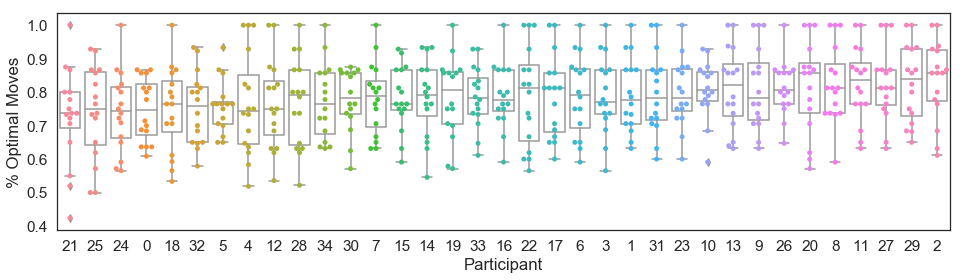

In [28]:
subject_df = pd.DataFrame([
    dict(problem=problem, pid=pid, percent=percent_optimal_moves[problem, pid])
    for problem, pid in np.ndindex(*percent_optimal_moves.shape)
])

f, ax = plt.subplots(figsize=(16, 4))
pid_to_mean = {pid: probs.percent.mean() for pid, probs in subject_df.groupby('pid')}
pid_order = sorted(subject_df.pid.unique(), key=lambda pid: pid_to_mean[pid])

#sns.violinplot(x='pid', y='percent', data=subject_df, ax=ax, order=pid_order)
#sns.swarmplot(x='pid', y='percent', data=subject_df, color='white', ax=ax, order=pid_order)

# or boxplot based
sns.boxplot(x='pid', y='percent', color='white', data=subject_df, ax=ax, order=pid_order)
sns.swarmplot(x='pid', y='percent', data=subject_df, ax=ax, order=pid_order)

ax.set_ylabel('% Optimal Moves')
ax.set_xlabel('Participant')

None

model_p.shape (12,) rand_p.shape (12,)
p_err.shape (50, 1) logp.shape (50, 12) total_logp.shape (50,)
MLE error prob: {'p_err': 0.32653061224489793, 'logp': -10.523567121978845}


/Users/carlos/pu/multigoals/analysis/model.py:23: RuntimeWarning: divide by zero encountered in log
  logp = np.log(noisy_model_p(p_err))


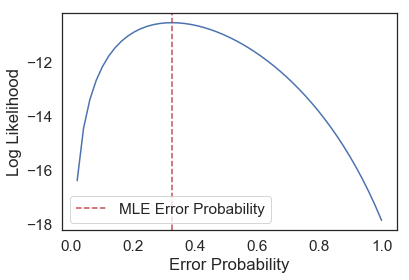

In [16]:
# Fit epsilon-greedy model

agent_idx = 0
problem = blockworld.Blockworld(row.states[0], goals_with_clearing)
model_p = p_actions
rand_p = np.array([1/len(problem.actions(s)) for s in row.states[:-1]])
print('model_p.shape', model_p.shape, 'rand_p.shape', rand_p.shape)
print('MLE error prob:', model.fit_epsilon_greedy_model(model_p, rand_p, debug=True))

In [160]:
agents = [
    (f'k={k}', dict(k=k))
    for k in [1, 2, 3, 4, 5] # HACK should make this flexible based on main problems?
] + [
    (f'd={d}', dict(depth_limit=d))
    for d in range(1, 10)
] + [
    ('k=1,d=4', dict(k=1, depth_limit=4)),
    ('k=2,d=4', dict(k=2, depth_limit=4)),
    ('k=2,d=6', dict(k=2, depth_limit=6)),
    ('k=4,d=6', dict(k=4, depth_limit=6)),
    ('k=4,d=8', dict(k=4, depth_limit=8)),
]

In [211]:
p_err = np.zeros((len(unique_problems_5block), len(df.pid.unique()), len(agents)))
logp = np.zeros((len(unique_problems_5block), len(df.pid.unique()), len(agents)))

# dict mapping (PID, agent_idx) to list of (initial state, p_actions (size # actions), rand_p (size # actions))
subject_actions_p = {}

# HACK it's good that we pick one problem and agent to solve for all people to exploit overlap in their states
# HACK or maybe it doesn't matter too much? depends on cache size I think
for problem_idx, initial in enumerate(tqdm(unique_problems_5block)):
    problem_rows = df.states.apply(lambda s: s[0] == initial)
    for _, row in df.loc[problem_rows].iterrows():
        for agent_idx, (agent_name, get_actions_kwargs) in enumerate(agents):
            get_actions_fn = lambda s: model.get_actions(s, **get_actions_kwargs)
            if agent_name == 'geom':
                p_actions = [model.geom_k_likelihood]
            else:
                p_actions = probability_of_actions_for_agent(row, get_actions_fn, uniform_action_selection=True)
            rand_p = np.array([1/len(problem.actions(s)) for s in row.states[:-1]])
            subject_actions_p.setdefault((row.pid, agent_idx), []).append((initial, p_actions, rand_p))
            fit = fit_p_err(p_actions, rand_p, debug=False)
            p_err[problem_idx, row.pid, agent_idx] = fit['p_err']
            logp[problem_idx, row.pid, agent_idx] = fit['logp']

None

/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


KeyboardInterrupt: 

p_actions.shape (162,) rand_p.shape (162,)
p_err.shape (50, 1) logp.shape (50, 162) total_logp.shape (50,)


/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


{'p_err': 0.16326530612244897, 'logp': -93.15569207209762}

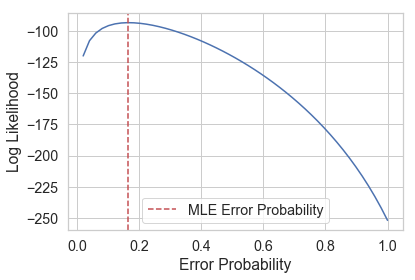

In [52]:
# Testing out code to fit p(error) for one participant across all actions

pid = 2 ; agent_idx = 2

results = subject_actions_p[pid, agent_idx]
p_actions = np.concatenate([p_actions for _, p_actions, rand_p in results], axis=0)
rand_p = np.concatenate([rand_p for _, p_actions, rand_p in results], axis=0)
assert p_actions.shape[0] == rand_p.shape[0]
print('p_actions.shape', p_actions.shape, 'rand_p.shape', rand_p.shape)
fit_p_err(p_actions, rand_p, debug=True)

In [53]:
# dict mapping (PID, agent name) to result of fit_p_err()
subject_p_err = {}

# Now we fit P(error) for each subject, for each agent across all actions
for (pid, agent_idx), results in tqdm(subject_actions_p.items()):
    agent_name, _ = agents[agent_idx]
    p_actions = np.concatenate([p_actions for _, p_actions, rand_p in results], axis=0)
    rand_p = np.concatenate([rand_p for _, p_actions, rand_p in results], axis=0)
    subject_p_err[pid, agent_name] = fit_p_err(p_actions, rand_p, debug=False)

/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


(15, 4, 14)
(4, 14)


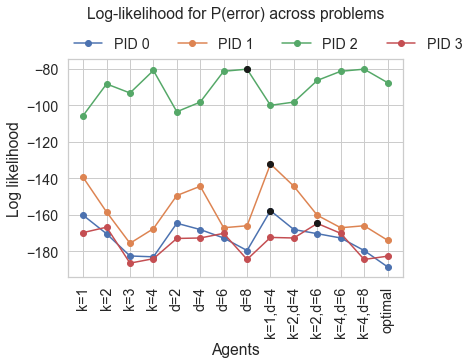

In [59]:
sns.set_style("whitegrid")
f, ax = plt.subplots()

print(logp.shape)
ll = np.sum(logp, axis=0)
print(ll.shape)

names = [name for name, _ in agents]
for pid in sorted(df.pid.unique()):
    ll = [subject_p_err[pid, name]['logp'] for name in names]
    ax.plot(names, ll, '-o', label=f'PID {pid}')
    max_agent = np.argmax(ll)
    max_dot = ax.plot(names[max_agent], ll[max_agent], 'o', c='k')

#ax.legend()
ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=4, 
            borderaxespad=0, frameon=False)

ax.set_title('Log-likelihood for P(error) across problems\n\n')
ax.set_xlabel('Agents')
ax.set_ylabel('Log likelihood')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)


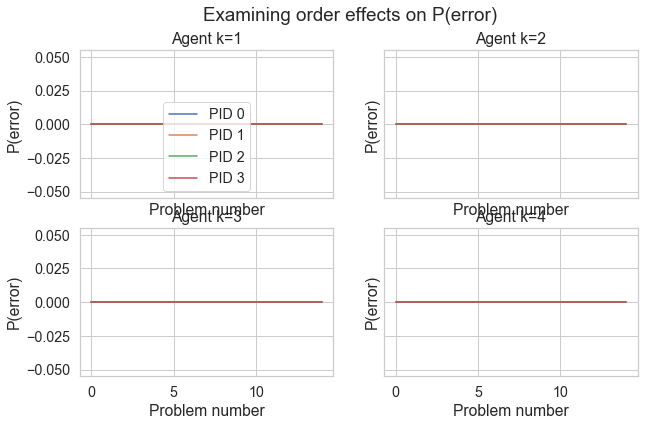

In [194]:
# looking at order effects

f, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)

f.suptitle('Examining order effects on P(error)')

for pid in sorted(fiveblock.pid.unique()):
    p_df = fiveblock.loc[fiveblock.pid == pid]
    for agent_idx, ((name, _), ax) in enumerate(zip(agents, axes.flat)):
        p_err_seq = p_err[p_df.problem_idx, pid, agent_idx]
        ax.plot(p_err_seq, label=f'PID {pid}')

for agent_idx, ((name, _), ax) in enumerate(zip(agents, axes.flat)):
    ax.set_title(f'Agent {name}')
    ax.set_ylabel('P(error)')
    ax.set_xlabel('Problem number')

ax = next(axes.flat)
ax.legend()

None

In [49]:
import random

def generate_actions(state, k=None, depth_limit=None, p=None, p_depth=None, p_err=0):
    '''
    Generate actions for agents. We assume that agents replan after each action.

    Can plan with depth limits, k limits (fixed, or with geometric distribution), and take noisy actions as well.
    '''
    problem = blockworld.Blockworld(state, model.make_goals(state))
    if k is None:
        k = len(problem.goals)
    if p is not None:
        k_dist = geom(p)
    if p_depth is not None:
        depth_dist = geom(p_depth)

    actions = []
    states = [state]

    while not problem.goal_test(state):
        if random.uniform(0, 1) < p_err:
            # Take random action
            action = random.choice(problem.actions(state))
            state = problem.result(state, action)
        else:
            if p is not None:
                k = k_dist.rvs()
            if p_depth is not None:
                depth_limit = depth_dist.rvs()
            next_goal, goal_test, h = agent.make_ordered_k_goal_cost_heuristic(problem, state, k=k, debug=False)
            planned_actions, planned_states = agent.A_Star(
                problem,
                h,
                start=state,
                goal_test=goal_test,
                depth_limit=depth_limit,
                shuffle=True)
            action = planned_actions[0]
            state = planned_states[1]
        actions.append(action)
        states.append(state)

    return actions, states

# Fiddling with toy problem. optimal is 5 move solutions.
initial = ((), ('D', 'A'), ('C', 'B'))
print('k=1', [len(generate_actions(initial, k=1)[0]) for _ in range(10)])
print('k=2 (optimal)', [len(generate_actions(initial, k=2)[0]) for _ in range(10)])
print('k=4 (optimal)', [len(generate_actions(initial, k=4)[0]) for _ in range(10)])
print('k=2 p_err', [len(generate_actions(initial, k=2, p_err=0.2)[0]) for _ in range(10)])
print('geom p=0.8', [len(generate_actions(initial, p=0.8)[0]) for _ in range(10)])
print('geom depth p=0.08', [len(generate_actions(initial, p_depth=0.08)[0]) for _ in range(10)])

k=1 [6, 5, 5, 6, 5, 6, 5, 5, 6, 6]
k=2 (optimal) [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
k=4 (optimal) [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
k=2 p_err [6, 13, 5, 5, 7, 7, 5, 7, 10, 9]
geom p=0.8 [6, 5, 5, 5, 6, 6, 5, 5, 5, 6]
geom depth p=0.08 [5, 5, 5, 5, 7, 6, 5, 5, 5, 5]


In [47]:
import json
with open('../../cocosci-blockworld/static/json/trials.json', 'r') as f:
    trials_json = json.load(f)

In [75]:
# parameter recovery: generate a dataset.

import random
random.seed(1338)

generated_df = dict(pid=[], states=[], actions=[])

letters = [chr(ord('a')+i) for i in range(5)]
# Set letter to empty string to jointly optimize
#letters = ['' for i in range(5)]


problems_to_test = problems_to_analyze
#problems_to_test = [tuple(tuple(col) for col in t['initial']) for t in trials_json['B=6']]

generating_agents = [
    (f'k=1{l}', dict(k=1)) for l in letters
] + [
    (f'k=2{l}', dict(k=2)) for l in letters
] + [
    (f'k=3{l}', dict(k=3)) for l in letters
] + [
    (f'k=4{l}', dict(k=4)) for l in letters
] + [
    (f'k=2{l} p_err', dict(k=2, p_err=0.2)) for l in letters
] + [
    (f'p=0.6 {l}', dict(p=0.6)) for l in letters
] + [
    (f'p=0.3 {l}', dict(p=0.3)) for l in letters
]

generating_agents = [
    (f'k=2{l}', dict(k=2)) for l in letters
] + [
    (f'p=0.5 {l}', dict(p=0.5)) for l in letters
] + [
    (f'p_depth=0.1 {l}', dict(p_depth=0.1)) for l in letters
]

for agent_name, agent_kwargs in generating_agents:
    for initial in problems_to_test:
#    hi = (('E', 'C'), ('A', 'B'), ('D',)) 
#    for initial in [hi]:
        '''
        problem = blockworld.Blockworld(initial, make_goals(initial))
        history, completed = agent.solve_using_ordered_goal_subset_astar(
            problem, debug=False, shuffle=True, **agent_kwargs)
        states = [s for a, s in history]
        actions = [a for a, s in history if a is not None]
        '''
        actions, states = generate_actions(initial, **agent_kwargs)
        assert len(actions) == len(states) - 1
        generated_df['states'].append(states)
        generated_df['actions'].append(actions)
        generated_df['pid'].append(agent_name)

generated_df = pd.DataFrame(generated_df)
generated_df.shape

(225, 3)

In [82]:
# parameter recovery: find p(action) for agents to this dataset

kvals = [1, 2, 3, 4, 5, 6]
dvals = range(1, 13)
agents = [
    (f'k={k}', dict(k=k))
    for k in kvals
] + [
    (f'd={d}', dict(depth_limit=d))
    for d in dvals
] + [
    (f'k={k},d={d}', dict(k=k, depth_limit=d))
    for k in kvals
    for d in dvals
]

def _make_model_inputs(df):
    curr_df = df.copy()
    curr_df['initial_state'] = curr_df['states'].apply(lambda s: s[0])

    # Some code for error likelihood. Assumes all states have same goals/# blocks
    arbitrary_state = curr_df['initial_state'].values[0]
    arbitrary_problem = blockworld.Blockworld(arbitrary_state, model.make_goals(arbitrary_state))
    def _err_likelihood(state, action):
        # HACK should we first check to see if action is even in there??
        return 1/len(arbitrary_problem.actions(state))

    # Indexed by (pid, initial state). Contains dict with
    # - model_p: (size # agents X # actions) and
    # - rand_p: (size # actions)
    subject_p = {
        (row.pid, row.initial_state): dict(
            model_p=np.zeros((len(agents), len(row.actions))),
            rand_p=np.zeros((len(row.actions),)),
        )
        for _, row in curr_df.iterrows()
    }

    # Modeling. We ensure innermost loop is over the same problem to best exploit LRU cache.
    # innermost loop with different problems or different agents would make it hard to cache
    # shared moves between participants.
    # This is ultimately why we structure data flow in this function in such a particular way.
    # HACK HACK however not clear that perf is really that impacted....
    # HACK although it might be by 6 block problems????
    for agent_idx, (agent_name, get_actions_kwargs) in enumerate(tqdm(agents)):
        get_actions_fn = lambda s: model.get_actions(s, **get_actions_kwargs)
        for _, rows in curr_df.groupby('initial_state'):
            for _, row in rows.iterrows():
                # Find or create our appropriate state
                subject_action_p = subject_p[row.pid, row.initial_state]
                for action_idx, (state, participant_action) in enumerate(zip(row.states[:-1], row.actions)):
                    subject_action_p['model_p'][agent_idx, action_idx] = model.probability_of_action(
                        state, participant_action, get_actions_fn,
                        uniform_action_selection=True)
                    subject_action_p['rand_p'][action_idx] = _err_likelihood(state, participant_action)

    # Now we make big matrices of model_p and rand_p for each subject
    model_inputs = {}
    for pid in curr_df['pid'].unique():
        m = []
        r = []
        # assumes every pid did every problem
        for initial_state in curr_df['initial_state'].unique():
            m.append(subject_p[pid, initial_state]['model_p'])
            r.append(subject_p[pid, initial_state]['rand_p'])
        model_inputs[pid] = dict(
            model_p=np.concatenate(m, axis=-1),
            rand_p=np.concatenate(r),
        )
    return model_inputs

curr_df = df_to_analyze

model_inputs = _make_model_inputs(curr_df)

In [110]:
import joblib
joblib.dump(dict(
    model_inputs=model_inputs,
    agent_names=agent_names,
), 'action_probs.z')

['action_probs.z']

In [111]:
action_probs = joblib.load('action_probs.z')

model_inputs = action_probs['model_inputs']
agent_names = action_probs['agent_names']

print('sample participant IDs:', list(model_inputs.keys())[:5])

participant_id = 6
model_p = model_inputs[participant_id]['model_p']
rand_p = model_inputs[participant_id]['rand_p']

print('len(agent_names)', len(agent_names)) # agent names, can be used to find a particular agent's probability of an action
print('model_p.shape', model_p.shape) # shape: # agents X # actions
print('rand_p.shape', rand_p.shape) # shape: # actions


sample participant IDs: [5, 4, 25, 33, 30]
len(agent_names) 90
model_p.shape (90, 260)
rand_p.shape (260,)


In [112]:
# Now fitting model

from scipy.optimize import minimize
from scipy.stats.distributions import geom, binom
import re

def _fit_models(problem, agent_names, action_lk, rand_p, random_x0=False):
    # Values of k to test. Right now we simplify by assuming all problems have same # of goals
    max_k = len(problem.goals)
    # HACK HACK
    kmatches = [re.match(r'^k=(\d+)$', agent_name) for agent_name in agent_names]
    max_k = max([int(m.group(1)) for m in kmatches if m])
    ks = np.arange(1, max_k+1)

    # Find indexes of k-agents in action_lk
    k_agent_idxs = [agent_names.index(f'k={k}') for k in ks]
    k_action_lk = action_lk[k_agent_idxs, :]

    # Values of d to test. We pick max value from agents
    dmatches = [re.match(r'^d=(\d+)$', agent_name) for agent_name in agent_names]
    max_d = max([int(m.group(1)) for m in dmatches if m])
    ds = np.arange(1, max_d+1)

    # Find indexes of d-agents in action_lk
    d_agent_idxs = [agent_names.index(f'd={d}') for d in ds]
    d_action_lk = action_lk[d_agent_idxs, :]

    # Find indexes of each pair of kd-agents in action_lk
    kd_agent_idxs = [
        [
            agent_names.index(f'k={k},d={d}')
            for d in ds
        ]
        for k in ks
    ]
    kd_action_lk = action_lk[kd_agent_idxs, :]
    assert kd_action_lk.shape == (len(ks), len(ds), len(rand_p))

    # Make sure shapes are good
    assert len(rand_p.shape) == 1
    assert action_lk.shape == (len(agent_names), len(rand_p))

    def _neg_ll(params):
        p, p_err = params
        # HACK for some reason this fn can get called by minimize() with an out of bounds value.
        p = max(min(p, 1), 0)
        p_err = max(min(p_err, 1), 0)

        # Set up geometric distribution over k
        pk = geom(p).pmf(ks)
        pk[-1] = 1 - pk[:-1].sum()  # tail probability of all k >= max_k

        # Determine model_p given this distribution over k
        model_p = pk.dot(k_action_lk)
        assert model_p.shape == rand_p.shape

        # Determine prob given prob of noise
        noisy_p = (1 - p_err) * model_p + p_err * rand_p

        return -np.log(noisy_p).sum()

    def _neg_ll_depth(params):
        # HACK HACK HACK copied from above...........
        p, p_err = params
        # HACK for some reason this fn can get called by minimize() with an out of bounds value.
        p = max(min(p, 1), 0)
        p_err = max(min(p_err, 1), 0)

        # Set up geometric distribution over d
        pd = geom(p).pmf(ds)
        pd[-1] = 1 - pd[:-1].sum()  # tail probability of all d >= max_d

        # Determine model_p given this distribution over d
        model_p = pd.dot(d_action_lk)
        assert model_p.shape == rand_p.shape

        # Determine prob given prob of noise
        noisy_p = (1 - p_err) * model_p + p_err * rand_p

        return -np.log(noisy_p).sum()

    def _neg_ll_k_and_depth(params):
        # HACK HACK HACK copied from above...........
        p_k, p_depth, p_err = params
        p_k = max(min(p_k, 1), 0)
        p_depth = max(min(p_depth, 1), 0)
        p_err = max(min(p_err, 1), 0)

        # Set up geometric distribution over k
        pk = geom(p_k).pmf(ks)
        pk[-1] = 1 - pk[:-1].sum()  # tail probability of all k >= max_k

        # Set up geometric distribution over d
        pd = geom(p_depth).pmf(ds)
        pd[-1] = 1 - pd[:-1].sum()  # tail probability of all d >= max_d

        # Set up distribution of k/d pairs
        joint_kd = pk[:, np.newaxis] * pd

        # Determine model_p given this distribution over k/d
        probs = joint_kd[:, :, np.newaxis] * kd_action_lk
        assert probs.shape == (len(ks), len(ds), len(rand_p))
        model_p = np.sum(probs, axis=(0, 1))
        assert model_p.shape == rand_p.shape

        # Determine prob given prob of noise
        noisy_p = (1 - p_err) * model_p + p_err * rand_p

        return -np.log(noisy_p).sum()

    def _neg_ll_noise(params, model_p):
        p_err, = params
        p_err = max(min(p_err, 1), 0)

        # Determine prob given prob of noise
        noisy_p = (1 - p_err) * model_p + p_err * rand_p

        #print('_neg_ll_noise', p_err, -np.log(noisy_p).sum())
        return -np.log(noisy_p).sum()

    out = {}

    # Trying to avoid issues when model_p can be 0
    safe_bounds = [1e-08, 1-1e-08]
    if random_x0:
        start_val = lambda: random.uniform(*safe_bounds)
    else:
        start_val = lambda: 0.5

    #for kidx, k in enumerate(ks):
    for agent_idx, agent_name in enumerate(agent_names):
        # Find model_p for this k
        model_p = action_lk[agent_idx, :]
        res = minimize(
            _neg_ll_noise, np.array([start_val()]), bounds=[safe_bounds],
            args=(model_p,), method='L-BFGS-B',
        )
        assert res.success, f'Model fitting failed. {res}'
        out[agent_name] = dict(p_err=res.x[0], logp=-res.fun)#, optres=res)

    res = minimize(_neg_ll, np.array([start_val(), start_val()]), bounds=[safe_bounds, safe_bounds], method='L-BFGS-B')
    assert res.success, f'Model fitting failed. {res}'
    p, p_err = res.x
    out['geom'] = dict(p=p, p_err=p_err, logp=-res.fun)#, optres=res)

    res = minimize(_neg_ll_depth, np.array([start_val(), start_val()]), bounds=[safe_bounds, safe_bounds], method='L-BFGS-B')
    assert res.success, f'Model fitting failed. {res}'
    p, p_err = res.x
    out['geom_depth'] = dict(p=p, p_err=p_err, logp=-res.fun)#, optres=res)

    res = minimize(
        _neg_ll_k_and_depth,
        np.array([start_val(), start_val(), start_val()]),
        bounds=[safe_bounds, safe_bounds, safe_bounds],
        method='L-BFGS-B')
    assert res.success, f'Model fitting failed. {res}'
    p_k, p_depth, p_err = res.x
    out['geom_kd'] = dict(p_k=p_k, p_depth=p_depth, p_err=p_err, logp=-res.fun)#, optres=res)

    return out

agent_names = [name for name, _ in agents]

In [114]:
arbitrary_state = problems_to_analyze[0]
arbitrary_problem = blockworld.Blockworld(arbitrary_state, model.make_goals(arbitrary_state))

pid_to_fit = {
    pid: _fit_models(arbitrary_problem, agent_names, model_inputs[pid]['model_p'], model_inputs[pid]['rand_p'])
    for pid in curr_df.pid.unique()
}

best result for binom: logp=-111.20122608944843 p_k 0.7741547215665787, p_err 0.012289058040538243, n_k 5
best result for geom: logp=-130.0189764590998 p_k 0.1506208150026058, p_err 0.006751769059989067, n_k 1
best result for binom using new method: logp=-90.55340693637689 p_k 0.99999999, p_err 0.06413126841854362, n_k 1


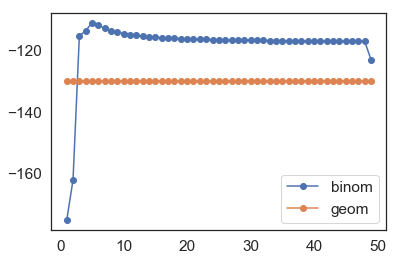

In [90]:
def _truncated_discrete_dist(dist, vals):
    '''
    Uses a discrete distribution to determine probabilities of the supplied ascending sequence which starts at 1.
    Probability for max value includes values larger than max value.
    '''
    # Set up discrete distribution over the values.
    # We assume the values are an increasing sequence, starting at 1.
    p = dist.pmf(vals)
    p[-1] = 1 - p[:-1].sum()  # We give largest value the tail probability of all values >= max value
    # HACK HACK what to do about value 0
    return p


def _noise_model_loglik(p_err, model_p, rand_p):
    # This is sometimes called with an out of bounds value
    p_err = max(min(p_err, 1), 0)

    # Determine prob given prob of noise
    noisy_p = (1 - p_err) * model_p + p_err * rand_p

    return np.log(noisy_p).sum()


def _latent_variable_model(params, action_lk, values, rand_p, _make_dist):
    p, p_err = params
    # HACK for some reason this fn can get called by minimize() with an out of bounds value.
    p = max(min(p, 1), 0)

    # Set up distribution over values
    p_of_value = _truncated_discrete_dist(_make_dist(p), values)

    # Determine model_p given this distribution over k
    model_p = p_of_value.dot(action_lk)
    assert model_p.shape == rand_p.shape

    return -_noise_model_loglik(p_err, model_p, rand_p)


def _simple_minimize(fn, num_params, args=(), random_x0=False):
    eps = 1e-08
    # Trying to avoid issues when a probability can be 0
    safe_bounds = [eps, 1-eps]
    if random_x0:
        start_val = lambda: random.uniform(*safe_bounds)
    else:
        start_val = lambda: 0.5

    x0 = [start_val() for _ in range(num_params)]
    res = minimize(
        fn,
        x0,
        bounds=[safe_bounds] * num_params,
        args=args,
        method='L-BFGS-B')
    assert res.success, f'Model fitting failed. {res}'
    #assert np.all(x0 != res.x), 'Model fit was the same as input parameters.'
    if np.any(x0 == res.x):
        return None
    return res


def _minimize_discrete_param(values, fit_model, repetitions=5):
    models = [
        (fit_model(value), value)
        for value in values
        for _ in range(repetitions)
    ]
    models = [(m, v) for (m, v) in models if m is not None]
    model, value = min(models, key=lambda model_and_value: model_and_value[0].fun)
    return model, value


def _hi(agent_names, action_lk, rand_p):
    kmatches = [re.match(r'^k=(\d+)$', agent_name) for agent_name in agent_names]
    max_k = max([int(m.group(1)) for m in kmatches if m])
    ks = np.arange(1, max_k+1)

    # Find indexes of k-agents in action_lk
    k_agent_idxs = [agent_names.index(f'k={k}') for k in ks]
    k_action_lk = action_lk[k_agent_idxs, :]

    # Values of d to test. We pick max value from agents
    dmatches = [re.match(r'^d=(\d+)$', agent_name) for agent_name in agent_names]
    max_d = max([int(m.group(1)) for m in dmatches if m])
    ds = np.arange(1, max_d+1)

    # Find indexes of d-agents in action_lk
    d_agent_idxs = [agent_names.index(f'd={d}') for d in ds]
    d_action_lk = action_lk[d_agent_idxs, :]

    for dist_name, dist_fn in [
        ('binom', lambda p: binom(n_k, p)),
        ('geom', lambda p: geom(p)),
    ]:
        logpss = []
        all_results = []
        for n_k in range(1, 50):
            r = [
                (_simple_minimize(_latent_variable_model, 2, args=(d_action_lk, ds, rand_p, dist_fn)), n_k)
                for _ in range(5)
            ]
            r = [(m, v) for (m, v) in r if m is not None]
            if not r:
                continue
            all_results += r
            # Find best fit
            res, _ = min(r, key=lambda res_and_n: res_and_n[0].fun)
            p_k, p_err = res.x
            logpss.append((n_k, -res.fun))
            #print('hi', n_k, f'logp={-res.fun} p_k={p_k} p_err={p_err}')
        res, n_k = min(all_results, key=lambda res_and_n: res_and_n[0].fun)
        p_k, p_err = res.x
        print(f'best result for {dist_name}: logp={-res.fun} p_k {p_k}, p_err {p_err}, n_k {n_k}')

        plt.plot(*zip(*logpss), '-o', label=dist_name)
    plt.legend()

    # using the nice new function...
    res, n_k = _minimize_discrete_param(
        range(1, 50),
        lambda n_k: _simple_minimize(_latent_variable_model, 2, args=(k_action_lk, ks, rand_p, lambda p: binom(n_k, p))))
    p_k, p_err = res.x
    print(f'best result for binom using new method: logp={-res.fun} p_k {p_k}, p_err {p_err}, n_k {n_k}')

pid = 6 # weird shape!
#for pid in tqdm(list(model_inputs.keys())[:10]):
plt.figure()
_hi(agent_names, model_inputs[pid]['model_p'], model_inputs[pid]['rand_p'])


In [116]:
def _add_binomial_models(pid_to_fit):
    # find k vals
    kmatches = [re.match(r'^k=(\d+)$', agent_name) for agent_name in agent_names]
    max_k = max([int(m.group(1)) for m in kmatches if m])
    ks = np.arange(1, max_k+1)
    k_agent_idxs = [agent_names.index(f'k={k}') for k in ks]

    # find d vals
    dmatches = [re.match(r'^d=(\d+)$', agent_name) for agent_name in agent_names]
    max_d = max([int(m.group(1)) for m in dmatches if m])
    ds = np.arange(1, max_d+1)
    d_agent_idxs = [agent_names.index(f'd={d}') for d in ds]

    for pid, fits in tqdm(pid_to_fit.items()):
        action_lk = model_inputs[pid]['model_p']
        rand_p = model_inputs[pid]['rand_p']

        for model_name, value_action_lk, values in [
            ('binom_k', action_lk[k_agent_idxs, :], ks),
            ('binom_d', action_lk[d_agent_idxs, :], ds),
        ]:
            # HACK just doing up to large # since some things actually like to go that far out...
            res, n = _minimize_discrete_param(range(1, 30), lambda n: _simple_minimize(
                _latent_variable_model,
                2,
                args=(value_action_lk, values, rand_p, lambda p: binom(n, p))))
            # HACK will res be None sometimes???
            p, p_err = res.x
            fits[model_name] = dict(p=p, p_err=p_err, n=n, logp=-res.fun)

_add_binomial_models(pid_to_fit)

In [313]:
# Comparing new model fits to old
for _ in range(3):
    pid = list(model_inputs.keys())[1]#'k=2a'
    print('pid', pid)

    arbitrary_state = problems_to_analyze[0]
    arbitrary_problem = blockworld.Blockworld(arbitrary_state, model.make_goals(arbitrary_state))

    i = model_inputs[pid]
    fits = _fit_models(arbitrary_problem, agent_names, i['model_p'], i['rand_p'], random_x0=True)
    for name, fit in fits.items():
        if 'k=' in name and 'd=' in name:
            continue
        print(name, fit)
    print()

# Now sanity checking against old code...
for agent_idx in [agent_names.index(f'k={k}') for k in range(1, 6)]:
    name, _ = agents[agent_idx]
    if 'k=' in name and 'd=' in name:
        continue
    print(name, model.fit_epsilon_greedy_model(i['model_p'][agent_idx, :], i['rand_p']))

pid 4
k=1 {'p_err': 0.14552209228381346, 'logp': -174.42237225190672}
k=2 {'p_err': 0.2690702747063718, 'logp': -255.31214575774396}
k=3 {'p_err': 0.2598894798847181, 'logp': -247.94666930866447}
k=4 {'p_err': 0.28325171633390883, 'logp': -256.37778695437987}
k=5 {'p_err': 0.3254204243714717, 'logp': -271.8957217129043}
k=6 {'p_err': 0.3320208780777126, 'logp': -272.7520512668315}
d=1 {'p_err': 0.07897226309946312, 'logp': -302.1241350064206}
d=2 {'p_err': 0.10453392001909897, 'logp': -246.3575669302364}
d=3 {'p_err': 0.10615195304881106, 'logp': -205.70248352900552}
d=4 {'p_err': 0.17664002072180426, 'logp': -230.81819373519357}
d=5 {'p_err': 0.1568037154464429, 'logp': -212.4806317376235}
d=6 {'p_err': 0.1916550048351875, 'logp': -246.3228084844123}
d=7 {'p_err': 0.2246627203643473, 'logp': -248.05270593635984}
d=8 {'p_err': 0.2522084708194608, 'logp': -251.6605388185227}
d=9 {'p_err': 0.2709278051195185, 'logp': -256.0458731896946}
d=10 {'p_err': 0.26278746516097695, 'logp': -253.39

/Users/carlos/pu/multigoals/analysis/model.py:23: RuntimeWarning: divide by zero encountered in log
  logp = np.log(noisy_model_p(p_err))


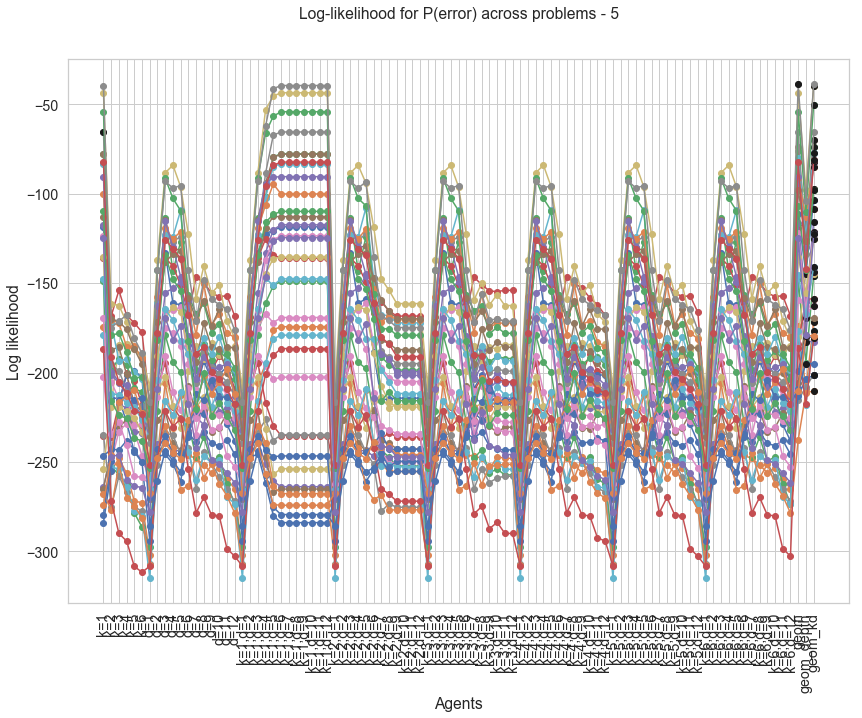

In [277]:
# parameter recovery

sns.set_style("whitegrid")

agent_names_for_plot = agent_names + ['geom', 'geom_depth', 'geom_kd']

all_pids = list(curr_df.pid.unique())
for pids in [
    all_pids,

    # chunking subjects into 5s
    #all_pids[idx:idx+5]
    #for idx in range(0, len(all_pids), 5)

    # works with newer code
    #[name for name, _ in generating_agents[idx:idx+len(letters)]]
    #for idx in range(0, len(generating_agents), len(letters))
]:
    f, ax = plt.subplots(figsize=(14, 10))

    #names = [name for name, _ in agents]
    for pid in pids:
        fits = pid_to_fit[pid]
        ll = np.array([fits[name]['logp'] for name in agent_names_for_plot])
        #ll = [subject_p_err[pid, name]['logp'] for name in names]
        ax.plot(agent_names_for_plot, ll, '-o', label=f'PID {pid}')
        max_agent = np.argmax(ll)
        max_dot = ax.plot(agent_names_for_plot[max_agent], ll[max_agent], 'o', c='k')

    #ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=4, 
    #            borderaxespad=0, frameon=False)

    ax.set_title(f'Log-likelihood for P(error) across problems - {list(pids)[0]}\n\n')
    ax.set_xlabel('Agents')
    ax.set_ylabel('Log likelihood')
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

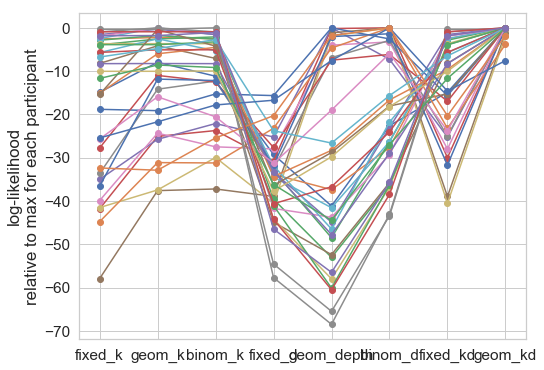

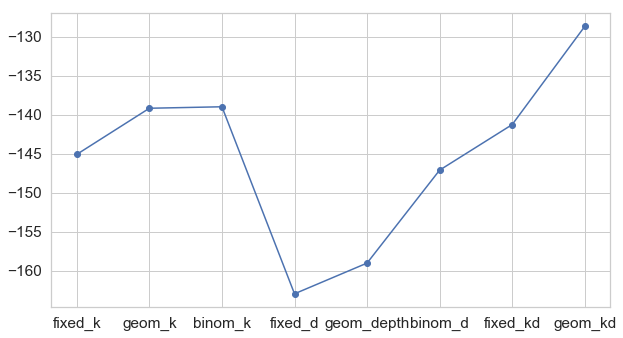

In [120]:
sns.set_style("whitegrid") 

f, ax = plt.subplots(figsize=(8, 6))

logp_df = []

for pid in curr_df.pid.unique():
    fits = pid_to_fit[pid]

    fixed_k_logp = max([
        fits[agent_name]['logp'] for agent_name in agent_names
        if re.match(r'^k=(\d+)$', agent_name)
    ])
    fixed_d_logp = max([
        fits[agent_name]['logp'] for agent_name in agent_names
        if re.match(r'^d=(\d+)$', agent_name)
    ])
    fixed_kd_logp = max([
        fits[agent_name]['logp'] for agent_name in agent_names
        if re.match(r'^k=(\d+),d=(\d+)$', agent_name)
    ])

    # four models, (fixed, geom) * (k, depth)
    hi = [
        dict(name='fixed_k', logp=fixed_k_logp),
        dict(name='geom_k', logp=fits['geom']['logp']),
        dict(name='binom_k', logp=fits['binom_k']['logp']),
        dict(name='fixed_d', logp=fixed_d_logp),
        dict(name='geom_depth', logp=fits['geom_depth']['logp']),
        dict(name='binom_d', logp=fits['binom_d']['logp']),
        dict(name='fixed_kd', logp=fixed_kd_logp),
        dict(name='geom_kd', logp=fits['geom_kd']['logp']),
    ]

    l = np.array([r['logp'] for r in hi])
    l -= np.max(l)
    ax.plot([r['name'] for r in hi], l, '-o')

    logp_df += hi

ax.set_ylabel('log-likelihood\nrelative to max for each participant')

logp_df = pd.DataFrame(logp_df)

x, y = zip(*[
    (name, logp_df.logp[logp_df.name==name].mean())
    for name in [item['name'] for item in hi]#, rows in logp_df.groupby('name')
])
f, ax = plt.subplots(figsize=(9, 5))
ax.plot(x, y, '-o')
#sns.lineplot(x='name', y='logp', data=logp_df, ax=ax)
plt.tight_layout()

/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Counts of models with max logp:
	geom_kd: 27
	geom_depth: 6
	k=1: 1
	geom: 1

Top 10 estimates of p for geom: [0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.9938053678546337, 0.9928259853851243, 0.9776278491094201, 0.9610442164375026, 0.9551983597767265]
sum(logp) for geom: -4871.238419191106

Top 10 estimates of p for geom_depth: [0.19483312489061605, 0.17375517263219997, 0.16762026790984325, 0.16681995039352276, 0.15566418565163057, 0.15513936849961169, 0.1532879327696375, 0.15125601361776542, 0.1506208150026058, 0.1506107274248907]
sum(logp) for geom_depth: -5565.05591833378

sum(logp) for geom_kd: -4504.715457558663


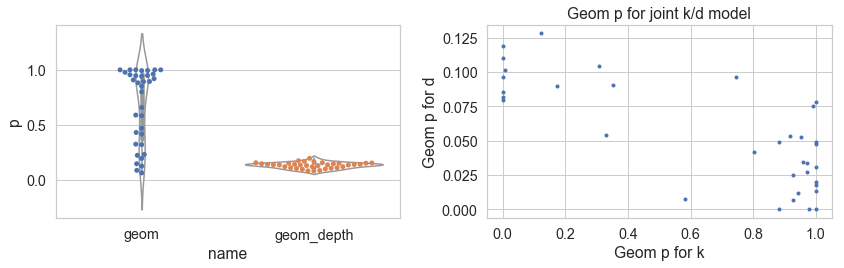

In [285]:
logp_df = []
from collections import Counter
max_ct = Counter()

for pid in curr_df.pid.unique():
    fits = pid_to_fit[pid]
    logp_df += [
        dict(p=fits[name]['p'], logp=fits[name]['logp'], name=name)
        for name in ['geom', 'geom_depth']
    ]
    keys = [k for k in fits.keys() if k != 'geom_kd']
    keys = fits.keys()
    max_key = max(keys, key=lambda k: fits[k]['logp'])
    max_ct[max_key] += 1

logp_df = pd.DataFrame(logp_df)

f, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.violinplot(x='name', y='p', data=logp_df, color='white', ax=ax)
sns.swarmplot(x='name', y='p', data=logp_df, ax=ax)

print('Counts of models with max logp:')
for k, ct in sorted(max_ct.items(), key=lambda pair: pair[-1], reverse=True):
    print(f'\t{k}: {ct}')
print()

for name, rows in logp_df.groupby('name'):
    print(f'Top 10 estimates of p for {name}: {sorted(rows.p.values, reverse=True)[:10]}')
    print(f'sum(logp) for {name}: {rows.logp.sum()}')
    print()

for name in ['geom_kd']:
    l = [pid_to_fit[pid][name]['logp'] for pid in curr_df.pid.unique()]
    print(f'sum(logp) for {name}: {np.sum(l)}')

ax2.set_title('Geom p for joint k/d model')
ax2.set_xlabel('Geom p for k')
ax2.set_ylabel('Geom p for d')
ax2.plot(
    [pid_to_fit[pid]['geom_kd']['p_k'] for pid in curr_df.pid.unique()],
    [pid_to_fit[pid]['geom_kd']['p_depth'] for pid in curr_df.pid.unique()], '.')

plt.tight_layout()

In [56]:
# Comparing new model fits to old

for pid in curr_df.pid.unique():
    print('pid', pid)
    i = model_inputs[pid]
    fits = _fit_models(arbitrary_problem, agent_names, i['model_p'], i['rand_p'])
    print('\t', 'geom', fits['geom'])
    other_max_fit_k = max([k for k in fits.keys() if k != 'geom'], key=lambda k: fits[k]['logp'])
    print('\t', 'next best fit:', other_max_fit_k, fits[other_max_fit_k])

pid 1
	 geom {'p': 0.5687475607769119, 'p_err': 0.15655588142279764, 'logp': -133.90925810109596}
	 next best fit: geom_depth {'p': 0.20530884851206993, 'p_err': 0.01327491182794864, 'logp': -123.67903471838532}
pid 2
	 geom {'p': 0.21908381098253865, 'p_err': 0.08190957961839689, 'logp': -74.76137158094168}
	 next best fit: geom_depth {'p': 0.08517012250933728, 'p_err': 1e-08, 'logp': -60.250918905430964}
pid 3
	 geom {'p': 0.4457164199717974, 'p_err': 0.17537701968050315, 'logp': -152.53269379904816}
	 next best fit: geom_depth {'p': 0.19282849051612636, 'p_err': 0.040094944119571735, 'logp': -144.26649902344997}
pid 0
	 geom {'p': 0.556492169302376, 'p_err': 0.18647637727691002, 'logp': -151.4958307440361}
	 next best fit: geom_depth {'p': 0.2128728262134545, 'p_err': 0.035431804145145546, 'logp': -140.46013961505122}
